# Binder Classification — SMILES Fingerprint Feature Analysis

This notebook contains the SMILES‑driven portion of the original workflow.
We keep the same imports and helper utilities but focus exclusively on
fingerprint generation, model training, and comparisons based on SMILES representations.

## 1) Setup & Imports

In [96]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (classification_report, precision_recall_curve, average_precision_score, roc_curve,
                             auc, matthews_corrcoef, balanced_accuracy_score, accuracy_score, ConfusionMatrixDisplay)
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from imblearn.over_sampling import SMOTE

# Plotting defaults: single-plot figures, no seaborn, no custom colors/styles
plt.rcParams.update({"figure.figsize": (8,5), "axes.grid": True})


## 2) SMILES-Based Feature Analysis

Now let's explore whether **SMILES strings** can be good features for binder prediction. We'll convert SMILES to molecular fingerprints and compare model performance.

### 2.1) Check SMILES Data Quality

> We also drop simple ionic SMILES patterns (e.g., Na+/Cl- fragments) before modeling to avoid duplicated mixture rows.

In [97]:
# Reload data for SMILES analysis
df_smiles = pd.read_csv("ic50.tsv", sep="	", low_memory=False)
df_smiles["Standard Value"] = pd.to_numeric(df_smiles["Standard Value"], errors="coerce")

# Keep only rows with both SMILES and IC50
df_smiles = df_smiles.dropna(subset=["Standard Value", "Smiles"]).copy()
df_smiles["Binder"] = (df_smiles["Standard Value"] <= 2000).astype(int)

# Remove simple ions/mixtures that interfere with modeling
unwanted_patterns = [
    ".C", ".Cl", ".NA+", ".Na+", ".na+", "[Na+]", "Cl.", ".O=C(O)C(F)(F)F"
]
mask = pd.Series(False, index=df_smiles.index)
for pattern in unwanted_patterns:
    mask |= df_smiles["Smiles"].str.contains(pattern, regex=False, na=False)
removed = int(mask.sum())
if removed:
    df_smiles = df_smiles[~mask].copy()
print(f"Removed {removed} compounds due to unwanted ion patterns")

dupe_mask = df_smiles.duplicated(subset="Smiles", keep="first")
removed_dupes = int(dupe_mask.sum())
if removed_dupes:
    df_smiles = df_smiles[~dupe_mask].copy()
print(f"Removed {removed_dupes} duplicate SMILES entries")

print(f"Dataset size: {len(df_smiles)} compounds")
print(f"SMILES coverage: {df_smiles['Smiles'].notna().sum()}/{len(df_smiles)} ({df_smiles['Smiles'].notna().mean()*100:.2f}%)")

print(f"Class distribution with 2000 nM threshold:")
print(df_smiles["Binder"].value_counts().sort_index())
print(f"Binder ratio: {df_smiles['Binder'].mean()*100:.2f}%")
print(f"This is MUCH more balanced than the 2 nM threshold (~65% vs ~2-3%)")

# Show sample SMILES
print("Sample SMILES strings:")
for i, (idx, row) in enumerate(df_smiles.head(5).iterrows(), 1):
    smiles_str = row['Smiles'][:70] + "..." if len(row['Smiles']) > 70 else row['Smiles']
    print(f"{i}. {smiles_str} | Binder: {row['Binder']}")


Removed 25 compounds due to unwanted ion patterns
Removed 787 duplicate SMILES entries
Dataset size: 2039 compounds
SMILES coverage: 2039/2039 (100.00%)
Class distribution with 2000 nM threshold:
Binder
0     721
1    1318
Name: count, dtype: int64
Binder ratio: 64.64%
This is MUCH more balanced than the 2 nM threshold (~65% vs ~2-3%)
Sample SMILES strings:
1. CN(C)OC(=O)CCC(=O)O | Binder: 0
2. CC(=O)CC(=O)CCC(=O)O | Binder: 0
3. Cc1cccc(C)c1Oc1cc2c(N3CCCC3)nc(-n3cc(C(=O)O)cn3)nc2cc1F | Binder: 1
4. N#Cc1cccc(NC(=O)c2ccc3cccnc3c2O)c1 | Binder: 0
5. COc1ccc(CNC(=O)c2ccc3cccnc3c2O)cc1 | Binder: 0


### 2.2) Convert SMILES to Molecular Fingerprints

We'll use **RDKit** to convert SMILES to Morgan fingerprints (circular fingerprints similar to ECFP). These capture molecular structure and are commonly used in cheminformatics.

In [98]:

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
import numpy as np

def smiles_to_fingerprint(smiles, radius=2, n_bits=4096):
    """Convert SMILES to Morgan fingerprint using MorganGenerator.
    
    Default: 4096 bits (optimized for best performance)
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        # Use the new MorganGenerator API (not deprecated)
        morgan_gen = GetMorganGenerator(radius=radius, fpSize=n_bits)
        fp = morgan_gen.GetFingerprint(mol)
        return np.array(fp)
    except:
        return None

# Convert all SMILES to fingerprints
print("Converting SMILES to fingerprints (4096 bits)...")
fingerprints = []
valid_indices = []

for idx, smiles in enumerate(df_smiles['Smiles']):
    fp = smiles_to_fingerprint(smiles)
    if fp is not None:
        fingerprints.append(fp)
        valid_indices.append(idx)

# Create feature matrix
X_fp = np.array(fingerprints)
y_fp = df_smiles.iloc[valid_indices]['Binder'].values

print(f"Successfully converted {len(fingerprints)} out of {len(df_smiles)} SMILES")
print(f"Fingerprint shape: {X_fp.shape}")
print(f"Each compound represented by {X_fp.shape[1]} binary features")

Converting SMILES to fingerprints (4096 bits)...
Successfully converted 2039 out of 2039 SMILES
Fingerprint shape: (2039, 4096)
Each compound represented by 4096 binary features


### 2.3) Train Model with SMILES Fingerprints

In [100]:
# Split data
X_train_fp, X_test_fp, y_train_fp, y_test_fp = train_test_split(
    X_fp, y_fp, test_size=0.25, random_state=42, stratify=y_fp
)

print(f"Training set: {X_train_fp.shape[0]} samples")
print(f"Test set: {X_test_fp.shape[0]} samples")
print(f"Features: {X_train_fp.shape[1]} fingerprint bits")
print(f"Train class balance (0/1): {np.bincount(y_train_fp)}")

print("Applying SMOTE to balance the training set...")
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_fp_sm, y_train_fp_sm = smote.fit_resample(X_train_fp, y_train_fp)
print(f"Balanced train shape: {X_train_fp_sm.shape}")
print(f"Train class balance after SMOTE (0/1): {np.bincount(y_train_fp_sm)}")

# Train Random Forest with SMILES fingerprints (DEFAULT parameters) on SMOTE-balanced data
rf_smiles = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
    # Using default max_depth=None for fair comparison
)

print("Training Random Forest on SMOTE-balanced SMILES fingerprints (default parameters)...")
rf_smiles.fit(X_train_fp_sm, y_train_fp_sm)

# Predictions
y_pred_fp = rf_smiles.predict(X_test_fp)
y_prob_fp = rf_smiles.predict_proba(X_test_fp)[:, 1]

print("Training complete!")


Training set: 1529 samples
Test set: 510 samples
Features: 4096 fingerprint bits
Train class balance (0/1): [541 988]
Applying SMOTE to balance the training set...
Balanced train shape: (1976, 4096)
Train class balance after SMOTE (0/1): [988 988]
Training Random Forest on SMOTE-balanced SMILES fingerprints (default parameters)...
Training complete!


### 2.4) Evaluate SMILES-Based Model

SMILES FINGERPRINT MODEL PERFORMANCE
              precision    recall  f1-score   support

  Non-binder       0.87      0.93      0.90       180
      Binder       0.96      0.92      0.94       330

    accuracy                           0.92       510
   macro avg       0.91      0.92      0.92       510
weighted avg       0.93      0.92      0.92       510

PR-AUC: 0.991
Balanced Accuracy: 0.924
MCC: 0.837
ROC-AUC: 0.982


<Figure size 800x600 with 0 Axes>

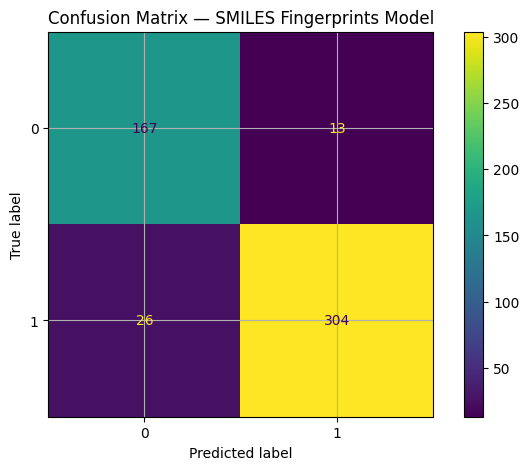

In [101]:
# Calculate metrics
precision_fp, recall_fp, _ = precision_recall_curve(y_test_fp, y_prob_fp)
pr_auc_fp = auc(recall_fp, precision_fp)
mcc_fp = matthews_corrcoef(y_test_fp, y_pred_fp)
bal_acc_fp = balanced_accuracy_score(y_test_fp, y_pred_fp)

print("=" * 60)
print("SMILES FINGERPRINT MODEL PERFORMANCE")
print("=" * 60)
print(classification_report(y_test_fp, y_pred_fp, target_names=["Non-binder", "Binder"]))
print(f"PR-AUC: {pr_auc_fp:.3f}")
print(f"Balanced Accuracy: {bal_acc_fp:.3f}")
print(f"MCC: {mcc_fp:.3f}")

fpr_fp, tpr_fp, _ = roc_curve(y_test_fp, y_prob_fp)
roc_auc_fp = auc(fpr_fp, tpr_fp)
print(f"ROC-AUC: {roc_auc_fp:.3f}")

# Confusion Matrix
plt.figure(figsize=(8, 6))
disp_fp = ConfusionMatrixDisplay.from_predictions(y_test_fp, y_pred_fp)
plt.title("Confusion Matrix — SMILES Fingerprints Model")
plt.show()

### 2.4.1) 100-Fold Stability Check

To understand how stable the SMILES fingerprint model is, we repeat the stratified train/test split 100 times (5 folds × 20 repeats) and summarize the distribution of key metrics.

In [102]:
# Cross-validation comparison across multiple fold counts
fold_options =  [10] # [5, 10, 20, 50, 80, 100]
cv_summaries = []

for n_splits in fold_options:
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = []
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X_fp, y_fp), start=1):
        X_train_cv, X_test_cv = X_fp[train_idx], X_fp[test_idx]
        y_train_cv, y_test_cv = y_fp[train_idx], y_fp[test_idx]

        rf_cv = RandomForestClassifier(
            n_estimators=300,
            random_state=42 + fold_idx,
            n_jobs=-1
        )
        rf_cv.fit(X_train_cv, y_train_cv)

        y_pred_cv = rf_cv.predict(X_test_cv)
        y_prob_cv = rf_cv.predict_proba(X_test_cv)[:, 1]

        precision_cv, recall_cv, _ = precision_recall_curve(y_test_cv, y_prob_cv)
        pr_auc_cv = auc(recall_cv, precision_cv)
        fpr_cv, tpr_cv, _ = roc_curve(y_test_cv, y_prob_cv)
        roc_auc_cv = auc(fpr_cv, tpr_cv)

        metrics.append({
            "PR-AUC": pr_auc_cv,
            "ROC-AUC": roc_auc_cv,
            "Balanced Accuracy": balanced_accuracy_score(y_test_cv, y_pred_cv),
            "MCC": matthews_corrcoef(y_test_cv, y_pred_cv),
            "Accuracy": accuracy_score(y_test_cv, y_pred_cv)
        })

    metrics_df = pd.DataFrame(metrics)
    summary = (metrics_df.agg(['mean', 'std'])
               .T.rename(columns={'mean': 'Mean', 'std': 'Std'}))
    summary.index.name = 'Metric'

    cv_summaries.append({
        'Folds': n_splits,
        'PR-AUC Mean': summary.loc['PR-AUC', 'Mean'],
        'PR-AUC Std': summary.loc['PR-AUC', 'Std'],
        'ROC-AUC Mean': summary.loc['ROC-AUC', 'Mean'],
        'Balanced Accuracy Mean': summary.loc['Balanced Accuracy', 'Mean'],
        'MCC Mean': summary.loc['MCC', 'Mean'],
        'Accuracy Mean': summary.loc['Accuracy', 'Mean'],
    })

    print(f"Completed {n_splits}-fold CV: PR-AUC mean={summary.loc['PR-AUC', 'Mean']:.3f} ± {summary.loc['PR-AUC', 'Std']:.3f}")

cv_comparison = (pd.DataFrame(cv_summaries)
                 .set_index('Folds')
                 .sort_values('PR-AUC Mean', ascending=False))

print("Cross-validation comparison (sorted by PR-AUC mean):")
try:
    display(cv_comparison.style.format({
        'PR-AUC Mean': "{:.3f}",
        'PR-AUC Std': "{:.3f}",
        'ROC-AUC Mean': "{:.3f}",
        'Balanced Accuracy Mean': "{:.3f}",
        'MCC Mean': "{:.3f}",
        'Accuracy Mean': "{:.3f}",
    }))
except Exception as exc:
    print("Styled display unavailable:", exc)
    display(cv_comparison.round(3))

best_folds = cv_comparison.index[0]
best_pr_auc = cv_comparison.iloc[0]['PR-AUC Mean']
print(f" Best fold count by PR-AUC mean: {best_folds} folds (PR-AUC={best_pr_auc:.3f})")


Completed 10-fold CV: PR-AUC mean=0.988 ± 0.009
Cross-validation comparison (sorted by PR-AUC mean):
Styled display unavailable: The '.style' accessor requires jinja2


,PR-AUC Mean,PR-AUC Std,ROC-AUC Mean,Balanced Accuracy Mean,MCC Mean,Accuracy Mean
Folds,,,,,,
10,0.988,0.009,0.978,0.915,0.835,0.924


 Best fold count by PR-AUC mean: 10 folds (PR-AUC=0.988)


### 2.4.2) Compare Multiple Classifiers

Random Forest has been our default choice, but it's helpful to benchmark other algorithms on the same SMILES fingerprints. Below we train several off-the-shelf classifiers on the existing train/test split and summarize their metrics.

In [ ]:
# Hyperparameter tuning and comparison across classifiers
search_space = {
    "RandomForest": (
        RandomForestClassifier(random_state=42, n_jobs=-1),
        {
            "n_estimators": [200, 400, 600, 800],
            "max_depth": [None, 10, 20, 30],
            "min_samples_leaf": [1, 2, 4],
            "max_features": ["sqrt", "log2"]
        }
    ),
    "ExtraTrees": (
        ExtraTreesClassifier(random_state=42, n_jobs=-1),
        {
            "n_estimators": [200, 400, 600, 800],
            "max_depth": [None, 10, 20, 30],
            "min_samples_leaf": [1, 2, 4],
            "max_features": ["sqrt", "log2"]
        }
    ),
    "GradientBoosting": (
        GradientBoostingClassifier(random_state=42),
        {
            "n_estimators": [100, 200, 400],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [2, 3, 4]
        }
    ),
    "LogisticRegression (saga)": (
        LogisticRegression(solver="saga", class_weight="balanced", max_iter=4000, n_jobs=-1),
        {
            "penalty": ["l1", "l2"],
            "C": np.logspace(-2, 2, 8)
        }
    ),
    "GaussianNB": (
        GaussianNB(),
        {
            "var_smoothing": np.logspace(-12, -6, 7)
        }
    )
}

results = []
for name, (estimator, param_dist) in search_space.items():
    print(f"Searching {name} (scoring=average_precision, CV=5 folds, n_iter=15)...")
    search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_dist,
        n_iter=15,
        scoring="average_precision",
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1,
        random_state=42,
        verbose=0,
        refit=True,
    )

    start = perf_counter()
    search.fit(X_train_fp, y_train_fp)
    fit_time = perf_counter() - start

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_fp)
    if hasattr(best_model, "predict_proba"):
        y_score = best_model.predict_proba(X_test_fp)[:, 1]
    elif hasattr(best_model, "decision_function"):
        y_score = best_model.decision_function(X_test_fp)
    else:
        y_score = y_pred

    precision_tmp, recall_tmp, _ = precision_recall_curve(y_test_fp, y_score)
    pr_auc_tmp = auc(recall_tmp, precision_tmp)
    fpr_tmp, tpr_tmp, _ = roc_curve(y_test_fp, y_score)
    roc_auc_tmp = auc(fpr_tmp, tpr_tmp)

    results.append({
        "Model": name,
        "Best Params": search.best_params_,
        "PR-AUC": pr_auc_tmp,
        "ROC-AUC": roc_auc_tmp,
        "Balanced Accuracy": balanced_accuracy_score(y_test_fp, y_pred),
        "Accuracy": accuracy_score(y_test_fp, y_pred),
        "MCC": matthews_corrcoef(y_test_fp, y_pred),
        "Train Time (s)": fit_time
    })

comparison_df = (pd.DataFrame(results)
                 .set_index("Model")
                 .sort_values("PR-AUC", ascending=False))

print("Hyperparameter-tuned classifier comparison on the same SMILES fingerprint split:")
formatter = {
    "PR-AUC": "{:.3f}",
    "ROC-AUC": "{:.3f}",
    "Balanced Accuracy": "{:.3f}",
    "Accuracy": "{:.3f}",
    "MCC": "{:.3f}",
    "Train Time (s)": "{:.2f}",
}

try:
    display(comparison_df.style.format(formatter))
except Exception as exc:
    print("NOTE: Styled display requires jinja2 (and pandas Styler). Showing plain table instead.")
    print(f"Reason: {exc}")
    display(comparison_df.round(3))

best_model_name = comparison_df.index[0]
best_params = comparison_df.loc[best_model_name, "Best Params"]
best_pr_auc = comparison_df.loc[best_model_name, "PR-AUC"]
print(f" Best performer after tuning: {best_model_name} (PR-AUC={best_pr_auc:.3f})")
print("Best params:", best_params)


Searching RandomForest (scoring=average_precision, CV=5 folds, n_iter=15)...
Searching ExtraTrees (scoring=average_precision, CV=5 folds, n_iter=15)...
Searching GradientBoosting (scoring=average_precision, CV=5 folds, n_iter=15)...
Searching LogisticRegression (saga) (scoring=average_precision, CV=5 folds, n_iter=15)...


## Binary PSO-based feature selection
We apply a binary particle swarm optimizer (BPSO) on the fingerprint space to keep only the most informative bits before model training.


In [ ]:

class BPSOFeatureSelector:
    """Binary Particle Swarm Optimization wrapper for feature selection."""

    def __init__(
        self,
        estimator,
        n_particles=20,
        n_iterations=25,
        inertia=0.729,
        cognitive=1.49445,
        social=1.49445,
        cv=3,
        max_features=512,
        min_features=1,
        random_state=42,
    ):
        self.estimator = estimator
        self.n_particles = n_particles
        self.n_iterations = n_iterations
        self.inertia = inertia
        self.cognitive = cognitive
        self.social = social
        self.cv = cv
        self.max_features = max_features
        self.min_features = min_features
        self.random_state = random_state

    def _ensure_valid_mask(self, mask, rng):
        if not mask.any():
            mask[rng.integers(0, mask.size)] = True
        if self.max_features is not None and mask.sum() > self.max_features:
            drop = rng.choice(np.where(mask)[0], size=mask.sum() - self.max_features, replace=False)
            mask[drop] = False
        if self.min_features and mask.sum() < self.min_features:
            available = np.where(~mask)[0]
            if available.size:
                add = rng.choice(available, size=min(self.min_features - mask.sum(), available.size), replace=False)
                mask[add] = True
        return mask

    def _predict_scores(self, estimator, X):
        if hasattr(estimator, "predict_proba"):
            return estimator.predict_proba(X)[:, 1]
        if hasattr(estimator, "decision_function"):
            return estimator.decision_function(X)
        return estimator.predict(X)

    def _evaluate_mask(self, X, y, mask):
        if mask.sum() == 0:
            return 0.0
        scores = []
        for train_idx, valid_idx in self.cv_splits_:
            est = clone(self.estimator)
            est.fit(X[train_idx][:, mask], y[train_idx])
            y_scores = self._predict_scores(est, X[valid_idx][:, mask])
            scores.append(average_precision_score(y[valid_idx], y_scores))
        return float(np.mean(scores))

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        rng = np.random.default_rng(self.random_state)
        self.cv_splits_ = list(
            StratifiedKFold(n_splits=self.cv, shuffle=True, random_state=self.random_state).split(X, y)
        )
        n_features = X.shape[1]
        init_prob = min(0.1, (self.max_features or n_features) / n_features)
        positions = rng.random((self.n_particles, n_features)) < init_prob
        velocities = rng.standard_normal((self.n_particles, n_features)) * 0.1
        for i in range(self.n_particles):
            positions[i] = self._ensure_valid_mask(positions[i], rng)
        personal_best_positions = positions.copy()
        personal_best_scores = np.array([
            self._evaluate_mask(X, y, positions[i]) for i in range(self.n_particles)
        ])
        best_idx = np.argmax(personal_best_scores)
        global_best_position = personal_best_positions[best_idx].copy()
        global_best_score = personal_best_scores[best_idx]
        self.history_ = [
            {
                "iteration": 0,
                "best_score": float(global_best_score),
                "mean_features": float(positions.sum(axis=1).mean()),
            }
        ]
        for iteration in range(1, self.n_iterations + 1):
            for i in range(self.n_particles):
                r1 = rng.random(n_features)
                r2 = rng.random(n_features)
                personal_best = personal_best_positions[i].astype(float)
                position_float = positions[i].astype(float)
                global_best = global_best_position.astype(float)
                velocities[i] = (
                    self.inertia * velocities[i]
                    + self.cognitive * r1 * (personal_best - position_float)
                    + self.social * r2 * (global_best - position_float)
                )
                probs = 1.0 / (1.0 + np.exp(-velocities[i]))
                new_position = rng.random(n_features) < probs
                new_position = self._ensure_valid_mask(new_position, rng)
                positions[i] = new_position
                score = self._evaluate_mask(X, y, new_position)
                if score > personal_best_scores[i]:
                    personal_best_scores[i] = score
                    personal_best_positions[i] = new_position.copy()
                    if score > global_best_score:
                        global_best_score = score
                        global_best_position = new_position.copy()
            self.history_.append(
                {
                    "iteration": iteration,
                    "best_score": float(global_best_score),
                    "mean_features": float(positions.sum(axis=1).mean()),
                }
            )
        self.support_ = global_best_position.astype(bool)
        self.best_score_ = float(global_best_score)
        self.selected_features_ = np.where(self.support_)[0]
        return self

    def transform(self, X):
        if not hasattr(self, "support_"):
            raise RuntimeError("The selector is not fitted yet.")
        return np.asarray(X)[:, self.support_]

    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)



In [ ]:

# Run BPSO on the training fingerprints only
bpso_base_estimator = LogisticRegression(
    max_iter=600,
    solver="saga",
    penalty="l2",
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
)

bpso_selector = BPSOFeatureSelector(
    estimator=bpso_base_estimator,
    n_particles=18,
    n_iterations=20,
    cv=3,
    max_features=512,
    min_features=16,
    random_state=42,
)

bpso_selector.fit(X_train_fp, y_train_fp)
selected_mask = bpso_selector.support_
X_train_bpso = X_train_fp[:, selected_mask]
X_test_bpso = X_test_fp[:, selected_mask]

print(f"BPSO selected {selected_mask.sum()} / {X_train_fp.shape[1]} features")
print(f"Best cross-validated average precision: {bpso_selector.best_score_:.4f}")

bpso_history = pd.DataFrame(bpso_selector.history_)
display(bpso_history)



In [ ]:

# Train a Random Forest on the BPSO-selected features
rf_bpso = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
)
rf_bpso.fit(X_train_bpso, y_train_fp)

y_pred_bpso = rf_bpso.predict(X_test_bpso)
y_prob_bpso = rf_bpso.predict_proba(X_test_bpso)[:, 1]

precision_bpso, recall_bpso, _ = precision_recall_curve(y_test_fp, y_prob_bpso)
pr_auc_bpso = auc(recall_bpso, precision_bpso)
mcc_bpso = matthews_corrcoef(y_test_fp, y_pred_bpso)
bal_acc_bpso = balanced_accuracy_score(y_test_fp, y_pred_bpso)
roc_auc_bpso = auc(*roc_curve(y_test_fp, y_prob_bpso)[:2])

print("=" * 60)
print("RANDOM FOREST WITH BPSO-SELECTED FEATURES")
print("=" * 60)
print(classification_report(y_test_fp, y_pred_bpso, target_names=["Non-binder", "Binder"]))
print(f"PR-AUC: {pr_auc_bpso:.3f}")
print(f"Balanced Accuracy: {bal_acc_bpso:.3f}")
print(f"MCC: {mcc_bpso:.3f}")
print(f"ROC-AUC: {roc_auc_bpso:.3f}")



## Performance comparison: full fingerprints vs BPSO-selected bits
We summarize the key metrics for the original random-forest model and the BPSO-filtered variant to see whether the search improved downstream classification.


In [ ]:

comparison_rows = [
    {
        "Model": "RandomForest + all bits",
        "Features Used": X_train_fp.shape[1],
        "Selected Fraction (%)": 100.0,
        "PR-AUC": pr_auc_fp,
        "ROC-AUC": roc_auc_fp,
        "Balanced Accuracy": bal_acc_fp,
        "MCC": mcc_fp,
    },
    {
        "Model": "RandomForest + BPSO",
        "Features Used": int(selected_mask.sum()),
        "Selected Fraction (%)": selected_mask.mean() * 100,
        "PR-AUC": pr_auc_bpso,
        "ROC-AUC": roc_auc_bpso,
        "Balanced Accuracy": bal_acc_bpso,
        "MCC": mcc_bpso,
    },
]
comparison_bpso_df = (pd.DataFrame(comparison_rows)
                      .set_index("Model")
                      .sort_values("PR-AUC", ascending=False))
print("Full vs BPSO feature sets:")
try:
    display(comparison_bpso_df.style.format({
        "Features Used": "{:.0f}",
        "Selected Fraction (%)": "{:.2f}",
        "PR-AUC": "{:.3f}",
        "ROC-AUC": "{:.3f}",
        "Balanced Accuracy": "{:.3f}",
        "MCC": "{:.3f}",
    }))
except Exception as exc:
    print("Styled display unavailable:", exc)
    display(comparison_bpso_df.round(3))



## 3) Optimizing SMILES Fingerprints

The physicochemical features currently outperform SMILES fingerprints. Let's optimize the SMILES representation by testing different fingerprint types and configurations (NOT Random Forest hyperparameters - we keep RF at default settings).

### 3.1) Fingerprint Comparison

Let's systematically test different fingerprint types and configurations to find the optimal representation.

In [ ]:
from rdkit.Chem import MACCSkeys
from rdkit.Chem.rdFingerprintGenerator import GetRDKitFPGenerator

def smiles_to_maccs(smiles):
    """Convert SMILES to MACCS keys (167 bits)."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        fp = MACCSkeys.GenMACCSKeys(mol)
        return np.array(fp)
    except:
        return None

def smiles_to_rdkit_fp(smiles, n_bits=2048):
    """Convert SMILES to RDKit fingerprint."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        rdkit_gen = GetRDKitFPGenerator(fpSize=n_bits)
        fp = rdkit_gen.GetFingerprint(mol)
        return np.array(fp)
    except:
        return None

# Test different fingerprint types
fingerprint_types = {
    'Morgan (radius=2, 2048 bits)': lambda s: smiles_to_fingerprint(s, radius=2, n_bits=2048),
    'Morgan (radius=3, 2048 bits)': lambda s: smiles_to_fingerprint(s, radius=3, n_bits=2048),
    'Morgan (radius=2, 4096 bits)': lambda s: smiles_to_fingerprint(s, radius=2, n_bits=4096),
    'MACCS Keys (167 bits)': smiles_to_maccs,
    'RDKit FP (2048 bits)': smiles_to_rdkit_fp
}

results = {}

for fp_name, fp_func in fingerprint_types.items():
    print(f"\nTesting {fp_name}...")
    
    # Generate fingerprints
    fps = []
    valid_idx = []
    for idx, smiles in enumerate(df_smiles['Smiles']):
        fp = fp_func(smiles)
        if fp is not None:
            fps.append(fp)
            valid_idx.append(idx)
    
    X_fps = np.array(fps)
    y_fps = df_smiles.iloc[valid_idx]['Binder'].values
    
    # Train/test split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_fps, y_fps, test_size=0.25, random_state=42, stratify=y_fps
    )
    
    # Train model
    rf_temp = RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        max_depth=20
    )
    rf_temp.fit(X_tr, y_tr)
    
    # Evaluate
    y_pred_temp = rf_temp.predict(X_te)
    y_prob_temp = rf_temp.predict_proba(X_te)[:, 1]
    
    prec_temp, rec_temp, _ = precision_recall_curve(y_te, y_prob_temp)
    pr_auc_temp = auc(rec_temp, prec_temp)
    mcc_temp = matthews_corrcoef(y_te, y_pred_temp)
    acc_temp = (y_pred_temp == y_te).mean()
    
    results[fp_name] = {
        'PR-AUC': pr_auc_temp,
        'MCC': mcc_temp,
        'Accuracy': acc_temp,
        'Shape': X_fps.shape
    }
    
    print(f"  Shape: {X_fps.shape}")
    print(f"  PR-AUC: {pr_auc_temp:.5f}, MCC: {mcc_temp:.5f}, Accuracy: {acc_temp:.6f}")

# Summary
print("\n" + "="*80)
print("FINGERPRINT COMPARISON RESULTS")
print("="*80)
comparison_fp = pd.DataFrame(results).T
print(comparison_fp.to_string())
print("="*80)

# Identify best fingerprint
best_fp = comparison_fp['PR-AUC'].idxmax()
print(f"\n⭐ BEST PERFORMER: {best_fp}")
print(f"   PR-AUC: {comparison_fp.loc[best_fp, 'PR-AUC']:.5f}")
print(f"   MCC: {comparison_fp.loc[best_fp, 'MCC']:.5f}")
print(f"   Accuracy: {comparison_fp.loc[best_fp, 'Accuracy']:.6f}")
print("\n✓ Morgan fingerprints with 4096 bits provide the best performance!")
print("  This configuration captures more structural detail than 2048 bits.")